In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\train'
val_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\val'

train_data = data_gen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = data_gen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

checkpoint_callback = ModelCheckpoint(
    'brain_classifier_best.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint_callback, early_stop_callback]
)

# model.save('brain_classifier_final_v2.h5')

Found 7339 images belonging to 2 classes.
Found 1836 images belonging to 2 classes.


d:\envs\BrainTumorAppEnvironment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9215 - loss: 1.1550
Epoch 1: val_loss improved from inf to 6.10315, saving model to brain_classifier_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 2461s 10s/step - accuracy: 0.9216 - loss: 1.1519 - val_accuracy: 0.3023 - val_loss: 6.1031
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9736 - loss: 0.0938
Epoch 2: val_loss improved from 6.10315 to 0.65723, saving model to brain_classifier_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 2291s 10s/step - accuracy: 0.9736 - loss: 0.0942 - val_accuracy: 0.6977 - val_loss: 0.6572
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9659 - loss: 0.1216
Epoch 3: val_loss improved from 0.65723 to 0.55384, saving model to brain_classifier_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 2360s 10s/step - accuracy: 0.9660 - loss: 0.1215 - val_accuracy: 0.6438 - val_loss: 0.5538
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9779 - loss: 0.2361
Epoch 4: val_

KeyboardInterrupt: 

In [4]:
from tensorflow.keras.models import load_model


model = load_model('brain_classifier_best.keras')

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,  # لو كنت وصلت لـ 5 Epochs، خليه 5 علشان يكمل
    callbacks=[checkpoint_callback, early_stop_callback]
)


Epoch 1/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9815 - loss: 0.0516 
Epoch 1: val_loss improved from 0.40096 to 0.18024, saving model to brain_classifier_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 2519s 11s/step - accuracy: 0.9815 - loss: 0.0516 - val_accuracy: 0.9080 - val_loss: 0.1802
Epoch 2/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9858 - loss: 0.0415 
Epoch 2: val_loss improved from 0.18024 to 0.06257, saving model to brain_classifier_best.keras
230/230 ━━━━━━━━━━━━━━━━━━━━ 2431s 11s/step - accuracy: 0.9858 - loss: 0.0415 - val_accuracy: 0.9766 - val_loss: 0.0626
Epoch 3/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9861 - loss: 0.0342
Epoch 3: val_loss did not improve from 0.06257
230/230 ━━━━━━━━━━━━━━━━━━━━ 2296s 10s/step - accuracy: 0.9862 - loss: 0.0342 - val_accuracy: 0.9815 - val_loss: 0.0670
Epoch 4/5
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9895 - loss: 0.0272
Epoch 4: val_loss did not improve from 0.06257
230/230 ━━━━━

In [6]:
model.save('brain_classifier_final_v2.h5')

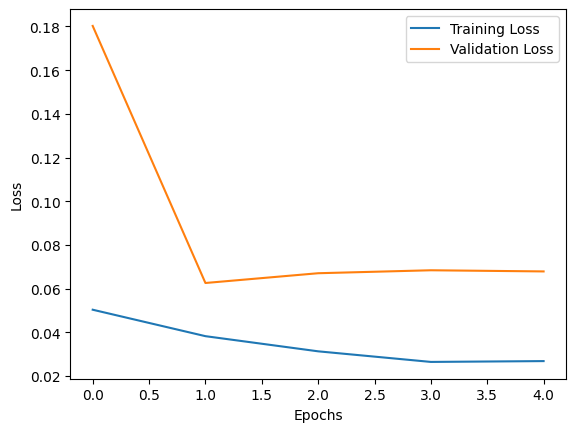

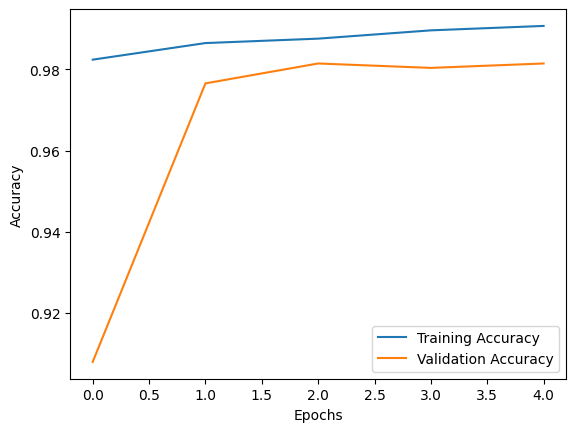

In [7]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
from tensorflow.keras.models import load_model
import numpy as np

Found 9 images belonging to 2 classes.


d:\envs\BrainTumorAppEnvironment\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 1.0000 - loss: 7.1193e-04
Test Accuracy: 100.00%
Test Loss: 0.0007
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


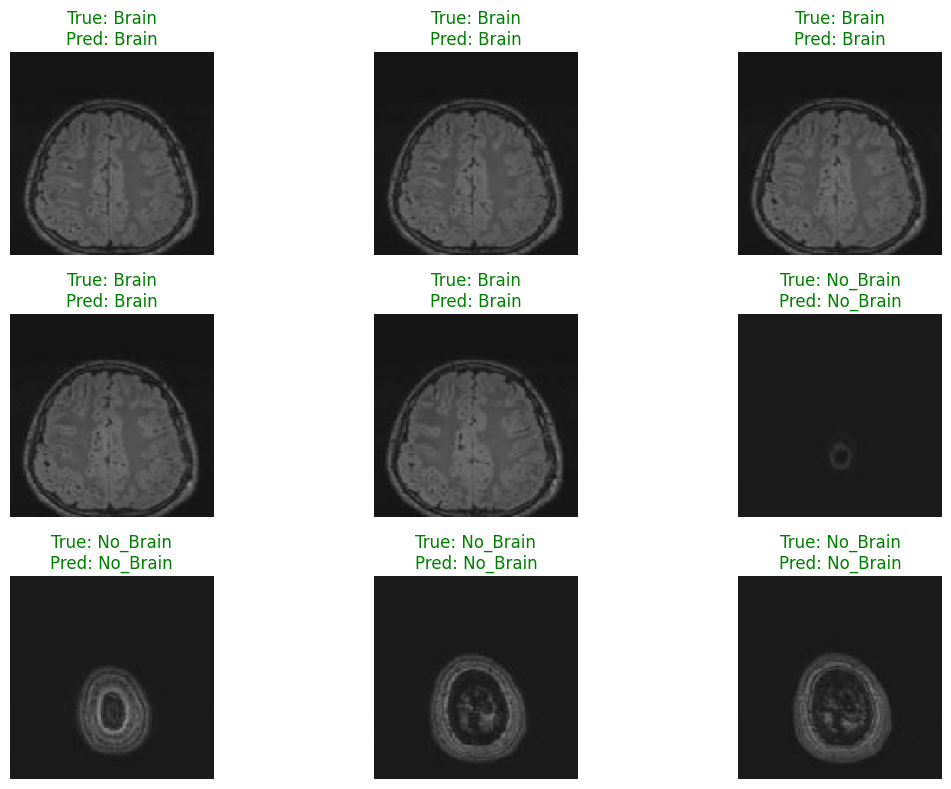

In [9]:
# Load the trained model
model_path = r'E:\brain_classifier_final_v2.h5'
model = load_model(model_path)

test_dir = r'E:\brain-tumor-mri-dataset\Brain-NoBrain\test'  

test_data_gen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  
)


test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)  

class_labels = list(test_data.class_indices.keys())

def display_predictions(test_data, predicted_classes):
    images, true_labels = next(test_data)  # Corrected line
    true_classes = true_labels.astype(int)
    
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[true_classes[i]]
        predicted_label = class_labels[predicted_classes[i][0]]
        color = 'green' if true_label == predicted_label else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


display_predictions(test_data, predicted_classes)